## Handwritten Digit Classifier using Neural Networks

In this project, we will build models that can classify images of handwritten digits (0-9) using deep learning or neural networks. 

The goal of this project is to:
1. Understand why image classification is a hard task
2. observe the limitations of traditional machine learning models for image classification
3. train, test, and improve a few different deep neural networks for image classification

A deep neural network is a specific type of neural network that excels at capturing nonlinear relationships in data. Deep learning is effective in image classification because of the models' ability to learn hierarchical representations. Neural networks are usually represented as graphs which let us compactly express a pipeline of functions that we want to be executed in succession. At the heart of neural network models is the successive computation of functions. This is known as a computational graph. A computational graph uses nodes to describe variables and edges to describe how variables are combined. Inspired by biological neural networks, an activation function determines if the neuron fires or not. In a neural network model, the activation function transforms the weighted sum of the input values.

We will be using load_digits function() which returns a copy of the __[hand-written dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)__ from UCI. It contains 1797 records. We will use different models with different layers and activation methods and check the prediction accuracy.

### Summary of Results
Highest accuracy of 95.99% was achieved using two hidden layers and 95.5% using "relu" activation method.

### Read Data

In [34]:
#Import required libraries
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [35]:
##The load_digits() function returns a copy of the hand-written digits dataset from UCI. Load the data as a numpy array
digits = load_digits()

#Check data shape
digits.data.shape

(1797, 64)

In [36]:
#Check keys
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [37]:
#Transform the NumPy 2D array into a pandas dataframe.
data = pd.DataFrame(digits["data"])

In [38]:
#Check data in the dataframe. Each image is represented as a row of pixel values. 
data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0


In [39]:
labels = pd.Series(digits["target"])

### Image Data
To visualize the image, we need to reshape these pixel values back into the 8 by 8 and plot them on a coordinate grid. To reshape the image, we need to convert the row data to a numpy array. 

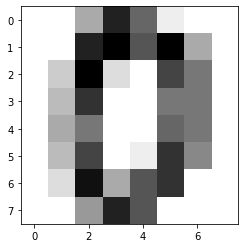

In [40]:
#Plot data for the first row
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

#Data is now in the right shape to be visualized
plt.imshow(np_image, cmap='gray_r')

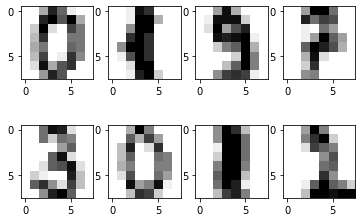

In [41]:
#Display data from multiple rows
f, axarr = plt.subplots(2, 4)

axarr[0, 0].imshow(data.iloc[0].values.reshape(8,8), cmap = 'gray_r')
axarr[0, 1].imshow(data.iloc[99].values.reshape(8,8), cmap='gray_r')
axarr[0, 2].imshow(data.iloc[199].values.reshape(8,8), cmap='gray_r')
axarr[0, 3].imshow(data.iloc[299].values.reshape(8,8), cmap='gray_r')

axarr[1, 0].imshow(data.iloc[999].values.reshape(8,8), cmap='gray_r')
axarr[1, 1].imshow(data.iloc[1099].values.reshape(8,8), cmap='gray_r')
axarr[1, 2].imshow(data.iloc[1199].values.reshape(8,8), cmap='gray_r')
axarr[1, 3].imshow(data.iloc[1299].values.reshape(8,8), cmap='gray_r')

### Difficulties in Image Classification
Image classification especially hand written images are difficult to classify because:
1. Each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.
2. Images are often reduced to lower resolutions and transformed to grayscale (no color). This is a limitation of compute power unfortunately. The resolution of a 8 megapixel photo has 3264 by 2448 pixels, for a total of 7,990,272 features (or about 8 million). Images of this resolution are usually scaled down to between 128 and 512 pixels in either direction for significantly faster processing. This often results in a loss of detail that's available for training and pattern matching.
3. The features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression. In grayscale, each pixel is just represented as a brightness value ranging from 0 to 256.
4. Many people write a single digit in very different styles. 

Deep learning is effective in image classification because of the models' ability to learn hierarchical representations. An effective deep learning model learns intermediate representations at each layer in the model and uses them in the prediction process. For example, in facial recocgnition, in the first hidden layer the network learns to represent edges and specific features of faces. In the second hidden layer, the weights represent higher level facial features like eyes and noses. Finally, the weights in the last hidden layer resemble faces. Each successive layer uses weights from previous layers to try to learn more complex representations.

### K-Nearest Neighbors Model
The k-nearest neighbors algorithm makes no assumptions about the linearity between the features and the output labels, hence this allows them to capture nonlinearity in the data. 

The k-nearest neighbors algorithm compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

We will start predicting the hand-written digits with KNN below. Before we start, we will create some generic functions to train the model, test data accuracy and cross validate data.

In [42]:
#Train model on train dataset 
def train(neighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    knn.fit(train_features, train_labels)
    return knn

In [43]:
#Compute accuracy of prediction on the test dataset
def test(knn, test_features, test_labels):
    predictions = knn.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df["correct labels"] = test_labels
    train_test_df["predicted labels"] = predictions
    accuracy = sum(train_test_df["predicted labels"] == train_test_df["correct labels"])/len(train_test_df)
    return accuracy

In [44]:
#cross_validate() function to perform 4-fold cross validation using train() and test() functions
def cross_validate(k, data,labels):
    fold_accuracies = []
    kf = KFold(n_splits=4, random_state=2)
    
    #Split data into train and test datasets for prediction
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        #Train model on train dataset
        knn_model = train(k, train_features, train_labels)
        #Get accuracy of prediction on the test dataset
        accuracy = test(knn_model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

Let us use KNN model to predict using 1 fold.

In [45]:
#Call function for k = 1
knn_1_accuracy = cross_validate(1, data, labels)
#Calculate the mean accuracy of all the folds
np.mean(knn_1_accuracy)

0.9677233358079684

Let us now vary the folds from 1 to 10.

Text(0.5, 1.0, 'MEAN ACUURACY Vs. k-VALUES')

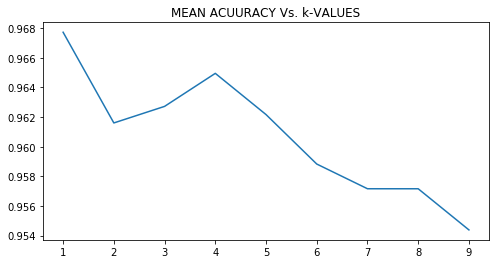

In [46]:
#Vary the k values from 1 to 10 and plot the accuracy
k_values = list(range(1,10))
k_overall_accuracies = []
for k in k_values:
    accuracy = cross_validate(k, data,labels)
    k_mean_accuracy = np.mean(accuracy)
    k_overall_accuracies.append(k_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.plot(k_values, k_overall_accuracies)
plt.title("MEAN ACUURACY Vs. k-VALUES")

We are getting the highest accuracy at k = 1 and the lowest at k = 9. There is no continuous trend of accuray values as k varies.

There are a few downsides to using k-nearest neighbors:
1. High memory usage (for each new unseen observation.
2. Many comparisons need to be made to seen observations) no model representation to debug and explore.

### Neural Network With One Hidden Layer
To make a prediction, a single layer of neural networks in these networks directly fed their results into the output neuron(s).
We will train our neural network using one hidden layer and varying neurons.

In [47]:
#Train model on train dataset 
def train(neurons, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neurons, max_iter=1000)
    mlp.fit(train_features, train_labels)
    return mlp

In [48]:
#Compute accuracy of prediction on the test dataset
def test(mlp, test_features, test_labels):
    predictions = mlp.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df["correct labels"] = test_labels
    train_test_df["predicted labels"] = predictions
    accuracy = sum(train_test_df["predicted labels"] == train_test_df["correct labels"])/len(train_test_df)
    return accuracy

In [49]:
#cross_validate() function to perform 4-fold cross validation using train() and test() functions
def cross_validate(neurons, data, labels):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state = 2)
    #Split data into train and test datasets for prediction
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        #Train model on train dataset 
        mlp_model = train(neurons, train_features, train_labels)
        #Get accuracy of prediction on the test dataset
        accuracy = test(mlp_model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

We will not train and test a neural network model using a single hidden layer with 8, 16, 32, 64, 128, 256 neurons and 4-fold cross validation.

In [50]:
#Using 4-fold cross validation: Train and test a neural network model using a single hidden layer with 8, 16, 32, 64, 128, 256 neurons
neurons_one = [(8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)]
mlp_accuracies = []

#Calculate accuracy for each number of neurons
for neuron in neurons_one:
    mlp_accuracy = cross_validate(neuron, data, labels)
    accuracy = np.mean(mlp_accuracy)
    mlp_accuracies.append(accuracy)

C:\Users\phtel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Let us plot the prediction accuracies using a single layer of neural networks.

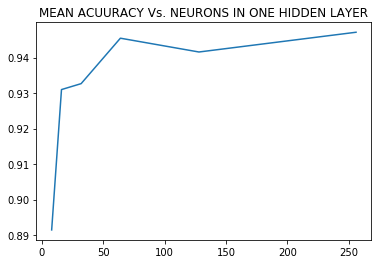

In [51]:
plt.figure(figsize=(8,4))

#Plot the accuracies for all number of neurons
%matplotlib inline 
plt.title("MEAN ACUURACY Vs. NEURONS IN ONE HIDDEN LAYER")
x = [i[0] for i in neurons_one]
plt.plot(x, mlp_accuracies)

In [52]:
print (mlp_accuracies)

[0.8914761197723335, 0.9309910913140312, 0.9326614699331849, 0.9454578074733976, 0.9415713932195001, 0.947133135362534]


It looks like adding more neurons to the single hidden layer helped massively improved simple accuracy from approximately 90% to approximately 95%. Simple accuracy computes the number of correct classifications the model made, but doesn't tell us anything about false or true positives or false or true negatives.

Given that k-nearest neighbors achieved approximately 96% accuracy, there doesn't seem to be any advantages to using a single hidden layer neural network for this problem.

### Neural Network With Two Hidden Layers
Multi-layer networks (also known as deep neural networks) are able to better capture nonlinearity in the data. In a deep neural network, the first layer of input neurons feeds into a second, intermediate layer of neurons.  We will modify the neural network training pipeline to use 2 hidden layers instead in the network.

In [53]:
#Using 4-fold cross validation: Train and test a neural network model using two hidden layers with (64, 64), (128, 128) and (256, 256) neurons in each layer.
neurons_two = [
    (64,64),
    (128,128),
    (256,256)
]
mlp_two_accuracies = []

#Calculate accuracy for each number of neurons
for neuron in neurons_two:
    mlp_two_accuracy = cross_validate(neuron, data, labels)
    accuracy_two = np.mean(mlp_two_accuracy)
    mlp_two_accuracies.append(accuracy_two)

Let us plot the prediction accuracies using a neural network with two hidden layers.

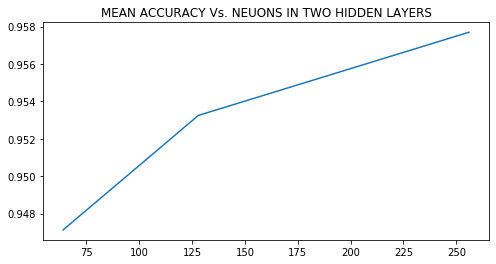

In [54]:
#Plot the accuracies for all number of neurons
plt.figure(figsize=(8,4))
plt.title("MEAN ACCURACY Vs. NEUONS IN TWO HIDDEN LAYERS")
x = [i[0] for i in neurons_two]
plt.plot(x, mlp_two_accuracies)

In [55]:
print (mlp_two_accuracies)

[0.9471306607275426, 0.9532541450136105, 0.9577010640930463]


With two hidden layers, the accuracy has slightly increased as compared with one hidden layer.

#### Neural Network With Three Hidden Layers
Modify the neural network training pipeline to use 3 hidden layers instead in the network.

In [56]:
#Using 4-fold cross validation: Train and test a neural network model using three hidden layers with (10, 10, 10), (64, 64, 64), (128, 128, 128) neurons in each layer.
neurons_three = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

mlp_three_accuracies = []

#Calculate accuracy for each number of neurons
for neurons in neurons_three:
    mlp_three_accuracy = cross_validate(neurons, data, labels)
    accuracy_three = np.mean(mlp_three_accuracy)
    mlp_three_accuracies.append(accuracy_three)

Let us plot the prediction accuracies using a neural network with three hidden layers.

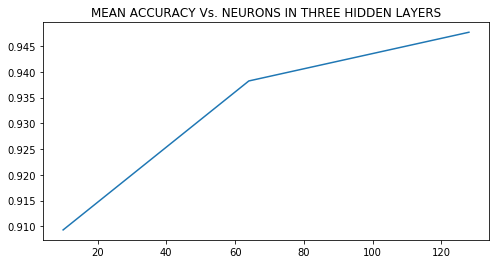

In [57]:
#Plot the accuracies for all number of neurons
plt.figure(figsize=(8,4))
plt.title("MEAN ACCURACY Vs. NEURONS IN THREE HIDDEN LAYERS")

x = [i[0] for i in neurons_three]
plt.plot(x, mlp_three_accuracies)

In [58]:
print (mlp_three_accuracies)

[0.9092959663449641, 0.9382232120762187, 0.9476812670131155]


We got the highest accuracy using two layers of 95.77%

### Different Activation Functions
The activation function transforms the weighted sum of the input values. This transformed output is then sen to the next layer of neurons as input. 
A neural network without an activation function is just a linear regression model. The activation function work on the non-linear transformation of the input making it capable to learn complex tasks.

We will use the relu and logistic activation functions.
1. ReLU stands for rectified linear unit and is defined as follows: ReLU(x) = max(0,x). The function call returns the maximum value between 0 and x.
2. In a binary classification problem, the target values are 0 and 1 and the relationship between the features and the target values is nonlinear. This means we need a function that can perform a nonlinear transformation of the input features. The sigmoid function is a good choice since all of its input values are squashed to range between 0 and 1.

In [59]:
#Train model on train dataset 
def train(neurons, act, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neurons, activation = act, max_iter=1000) #Activation added
    mlp.fit(train_features, train_labels)
    return mlp

In [60]:
#Compute accuracy of prediction on the test dataset
def test(mlp, test_features, test_labels):
    predictions = mlp.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df["correct labels"] = test_labels
    train_test_df["predicted labels"] = predictions
    accuracy = sum(train_test_df["predicted labels"] == train_test_df["correct labels"])/len(train_test_df)
    return accuracy

In [61]:
#cross_validate() function to perform 4-fold cross validation using train() and test() functions
def cross_validate(neurons, act, data,labels):
    fold_accuracies = []
    kf = KFold(n_splits=4, random_state=2)
    #Split data into train and test datasets for prediction
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        #Train model on train dataset 
        mlp_model = train(neurons, act, train_features, train_labels)
        #Get accuracy of prediction on the test dataset
        accuracy = test(mlp_model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

As we got the highest accuracy using two hidden layers, let us use this on the sigmoid and relu activation function.

In [62]:
#Check accuracy using two hidden layers and different activation functions
neurons_two = [
    (64,64),
    (128,128),
    (256,256)
]
mlp_two_accuracies = []
mlp_two_accuracies_relu = []

#Compute accuracy with activation function "logistic" (non-linear)
for neuron in neurons_two:
    mlp_two_accuracy = cross_validate(neuron, "logistic", data, labels)
    accuracy_two = np.mean(mlp_two_accuracy)
    mlp_two_accuracies.append(accuracy_two)
    
#Compute accuracy with activation function "relu" (linear)
for neuron in neurons_two:
    mlp_two_accuracy_relu = cross_validate(neuron, "relu", data, labels)
    accuracy_two_relu = np.mean(mlp_two_accuracy_relu)
    mlp_two_accuracies_relu.append(accuracy_two_relu)    

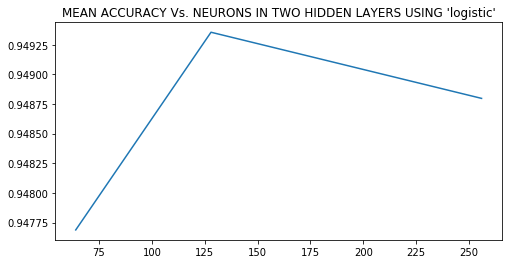

In [63]:
#Plot the accuracies for all number of neurons
plt.figure(figsize=(8,4))
plt.title("MEAN ACCURACY Vs. NEURONS IN TWO HIDDEN LAYERS USING 'logistic'")
x = [i[0] for i in neurons_two]
plt.plot(x, mlp_two_accuracies)

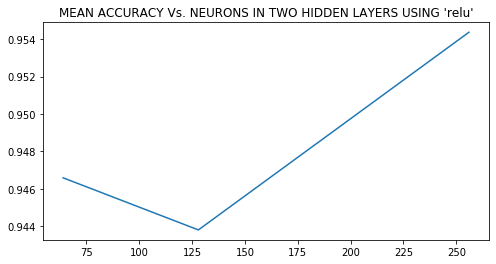

In [64]:
plt.figure(figsize=(8,4))
plt.title("MEAN ACCURACY Vs. NEURONS IN TWO HIDDEN LAYERS USING 'relu'")
x = [i[0] for i in neurons_two]
plt.plot(x, mlp_two_accuracies_relu)

In [65]:
print (mlp_two_accuracies)
print (mlp_two_accuracies_relu)

[0.9476874536005939, 0.9493553575847562, 0.9487973273942093]
[0.9465825290769612, 0.9437960900767136, 0.9543689680772087]


We got an accuracy of 95.5% using "relu" activation method.

In [66]:
#Check accuracy using three hidden layers and different activation functions
neurons_three = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

mlp_three_accuracies = []
mlp_three_accuracies_relu = []

#Compute accuracy with activation function "logistic" (non-linear)
for neurons in neurons_three:
    mlp_three_accuracy = cross_validate(neurons, "logistic", data, labels)
    accuracy_three = np.mean(mlp_three_accuracy)
    mlp_three_accuracies.append(accuracy_three)

#Compute accuracy with activation function "relu" (linear)
for neurons in neurons_three:
    mlp_three_accuracy_relu = cross_validate(neurons, "relu", data, labels)
    accuracy_three_relu = np.mean(mlp_three_accuracy_relu)
    mlp_three_accuracies_relu.append(accuracy_three_relu)

C:\Users\phtel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\phtel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [67]:
print (mlp_three_accuracies)
print (mlp_three_accuracies_relu)

[0.8386166790398416, 0.9343194753773818, 0.9404540955209107]
[0.9009378866617175, 0.9432343479336798, 0.9515850037119526]


The accuracy did not improve using the hidden networks with three neurons using different activation methods.

### Decision Tree Model
Let us check the accuracy using the decision tree model. Decision trees can pick up nonlinear interactions between variables in the data that linear regression can't, but they also tend to overfit and prone to instability to small changes in input data.

In [68]:
#Train model on train dataset 
def train(splits, train_features, train_labels):
    clf = DecisionTreeClassifier(random_state=1, min_samples_split = splits)
    clf.fit(train_features, train_labels)
    return clf

In [69]:
#Compute accuracy of prediction on the test dataset
def test(clf, test_features, test_labels):
    predictions = clf.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df["correct labels"] = test_labels
    train_test_df["predicted labels"] = predictions
    accuracy = sum(train_test_df["predicted labels"] == train_test_df["correct labels"])/len(train_test_df)
    return accuracy

In [70]:
#cross_validate() function to perform 6-fold cross validation using train() and test() functions
def cross_validate(splits, data,labels):
    fold_accuracies = []
    kf = KFold(n_splits=6, random_state=2)
    #Split data into train and test datasets for prediction
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        #Train model on train dataset 
        clf_model = train(splits, train_features, train_labels)
        #Get accuracy of prediction on the test dataset
        accuracy = test(clf_model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

Text(0.5, 1.0, 'MEAN ACCURACY Vs. SPLITS')

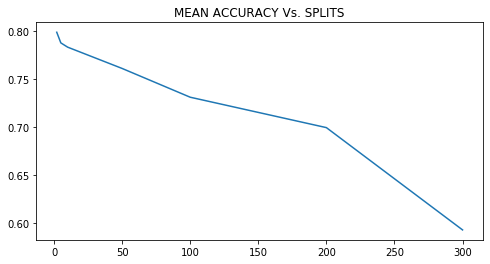

In [71]:
#Check accuracy for different number of splits
splits = [2, 5, 10, 50, 100, 200, 300]
clf_accuracies = []
for k in splits:
    accuracy = cross_validate(k, data,labels)
    clf_mean_accuracy = np.mean(accuracy)
    clf_accuracies.append(clf_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.plot(splits, clf_accuracies)
plt.title("MEAN ACCURACY Vs. SPLITS")

In [72]:
print (clf_accuracies)

[0.7991341508732814, 0.7880230397621703, 0.7835674470457078, 0.7613210702341137, 0.7312764771460424, 0.6995299145299145, 0.5926867335562988]


The highest accuracy achieved using Decision tree model was 80% with 2 splits. As the splits increased, the accuracy dropped.

### Ramdom Forest Model
Let us check the accuracy using Random Forest model. Random Forest algorithm performs both classification and regression tasks using ensembling. Ensembling is done by training multiple decision trees on different data samples built by replacement. It combines the predictions of multiple models to create a more accurate final prediction. One of the major advantages of random forests over single decision trees is that they tend to overfit less.

In [73]:
#Train model on train dataset 
def train(est, splits, train_features, train_labels):
    rfm = RandomForestClassifier(n_estimators = est, random_state=1, min_samples_leaf = splits)
    rfm.fit(train_features, train_labels)
    return rfm

In [74]:
#Compute accuracy of prediction on the test dataset
def test(rfm, test_features, test_labels):
    predictions = rfm.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df["correct labels"] = test_labels
    train_test_df["predicted labels"] = predictions
    accuracy = sum(train_test_df["predicted labels"] == train_test_df["correct labels"])/len(train_test_df)
    return accuracy

In [75]:
#cross_validate() function to perform 6-fold cross validation using train() and test() functions
def cross_validate(est, splits, data,labels):
    fold_accuracies = []
    kf = KFold(n_splits=6, random_state=2)
    #Split data into train and test datasets for prediction
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        #Train model on train dataset 
        rfm_model = train(est, splits, train_features, train_labels)
        #Get accuracy of prediction on the test dataset
        accuracy = test(rfm_model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

Text(0.5, 1.0, 'MEAN ACCURACY Vs. SPLITS')

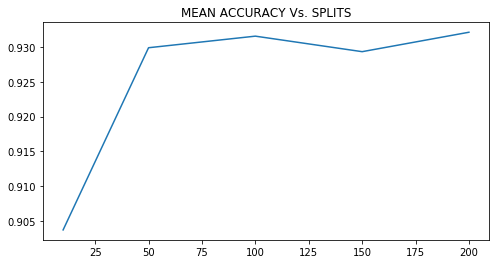

In [76]:
est = [10, 50, 100, 150, 200]
rfm_accuracies = []
for k in est:
    accuracy = cross_validate(int(k), 5, data,labels)
    rfm_mean_accuracy = np.mean(accuracy)
    rfm_accuracies.append(rfm_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.plot(est, rfm_accuracies)
plt.title("MEAN ACCURACY Vs. SPLITS")

In [77]:
print (rfm_accuracies)

[0.9037346711259754, 0.929890375325158, 0.931553325901152, 0.9293255295429209, 0.9321144555927164]


Using random forest also, we are getting an accuracy of around 93%, which is not different from the accuracies we got using hidden layers.

### Conclusion
We trained our data using KNN model, neural network models with different hidden layers and activation methods, decision tree model and random forest model. We got the highest accuracy of 95.99% using two hidden layers and 95.5% using "relu" activation method.